<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-for-modelling" data-toc-modified-id="Data-for-modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data for modelling</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Logistic-Regression-with-p-values" data-toc-modified-id="Logistic-Regression-with-p-values-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Logistic Regression with p-values</a></span></li><li><span><a href="#Feature-selection-using-p_values" data-toc-modified-id="Feature-selection-using-p_values-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Feature selection using p_values</a></span></li><li><span><a href="#Logistic-Regression-with-p-values-selected-features" data-toc-modified-id="Logistic-Regression-with-p-values-selected-features-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Logistic Regression with p-values selected features</a></span></li><li><span><a href="#Model-evaluation-on-test-data" data-toc-modified-id="Model-evaluation-on-test-data-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Model evaluation on test data</a></span></li><li><span><a href="#Predicted-Probabilities" data-toc-modified-id="Predicted-Probabilities-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Predicted Probabilities</a></span></li><li><span><a href="#Model-evaluation:-confusion-matrix" data-toc-modified-id="Model-evaluation:-confusion-matrix-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>Model evaluation: confusion matrix</a></span></li><li><span><a href="#Model-evaluation:-AUC" data-toc-modified-id="Model-evaluation:-AUC-6.8"><span class="toc-item-num">6.8&nbsp;&nbsp;</span>Model evaluation: AUC</a></span></li><li><span><a href="#Sort-by-yhat_prob-and-find-Gini-and-Kolmogorov-Smirnov" data-toc-modified-id="Sort-by-yhat_prob-and-find-Gini-and-Kolmogorov-Smirnov-6.9"><span class="toc-item-num">6.9&nbsp;&nbsp;</span>Sort by yhat_prob and find Gini and Kolmogorov-Smirnov</a></span></li><li><span><a href="#Plot-Gini-Curve" data-toc-modified-id="Plot-Gini-Curve-6.10"><span class="toc-item-num">6.10&nbsp;&nbsp;</span>Plot Gini Curve</a></span></li><li><span><a href="#Plot-K-S-curve" data-toc-modified-id="Plot-K-S-curve-6.11"><span class="toc-item-num">6.11&nbsp;&nbsp;</span>Plot K-S curve</a></span></li></ul></li><li><span><a href="#Create-Scorecard" data-toc-modified-id="Create-Scorecard-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create Scorecard</a></span></li></ul></div>

# Description

![](../images/EL_1.png)
![](../images/PD.png)
![](../images/LGD_1.png)
![](../images/EAD_1.png)
![](../images/loan_to_value.png)
![](../images/EAD_calculation.png)

# Imports

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
# my personal library
from bhishan import bp

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.plotting.register_matplotlib_converters()

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') 

# random state
SEED=100

[(x.__name__,x.__version__) for x in [np,pd,sns]]

[('numpy', '1.18.1'), ('pandas', '1.0.1'), ('seaborn', '0.9.0')]

In [6]:
pd.options.display.max_rows = 100

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [9]:
import scipy.stats as stats

# Useful Functions

In [10]:
class LogisticRegressionWithPvalues:
    """Logistic Regression with p-values.
    
    Usage:
    model = LogisticRegressionWithPvalues(
              n_jobs=-1,solver='lbfgs',random_state=SEED)
              
    model.fit(Xtrain,ytrain)
    model.model.predict(Xtest,ytest) #!! NOT: model.predict(Xtest)
    
    """
    def __init__(self,*args,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + 
                        np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stats.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

# Load the data

In [11]:
!ls ../data/processed

Xtest.csv            Xtrain.csv           dummy_variables.xlsx ytest.csv            ytrain.csv


In [12]:
dat_pro = '../data/processed/'

In [13]:
Xtrain = pd.read_csv(dat_pro + 'Xtrain.csv',index_col=0)
ytrain = pd.read_csv(dat_pro + 'ytrain.csv',index_col=0)
Xtest = pd.read_csv(dat_pro + 'Xtest.csv',index_col=0)
ytest = pd.read_csv(dat_pro + 'ytest.csv',index_col=0)

In [14]:
Xtrain.shape, ytrain.shape,Xtest.shape,ytest.shape

((373028, 351), (373028, 1), (93257, 351), (93257, 1))

In [15]:
Xtrain.head(2)

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:32.2_32.9,dti:32.9_33.6,dti:>=33.6,mths_since_last_record:missing,mths_since_last_record:0_2,mths_since_last_record:3_22,mths_since_last_record:23_46,mths_since_last_record:47_68,mths_since_last_record:69_85,mths_since_last_record:>=86
366463,366463,18514656,20677353,4000,4000,4000.0,36 months,16.29,141.21,D,...,0,0,0,0,0,0,0,0,0,1
409215,409215,14388577,16430959,10000,10000,10000.0,36 months,11.99,332.10,B,...,0,0,0,0,0,0,0,0,0,1


In [16]:
ytrain['good_bad'].value_counts()

1    332252
0     40776
Name: good_bad, dtype: int64

In [17]:
xls = pd.ExcelFile(dat_pro + 'dummy_variables.xlsx')
print(xls.sheet_names)
df_features = xls.parse(0,header=None,names=['feature'])
df_references = xls.parse(1,header=None,names=['reference'])

['dummy', 'reference']


In [18]:
print(df_features.shape)
df_features.head(2).append(df_features.tail(2))

(164, 1)


,feature
0,grade:A
1,grade:B
162,mths_since_last_record:69_85
163,mths_since_last_record:>=86


In [19]:
df_features['orig_feature'] = df_features['feature'].str.split(':').str[0]

df_features.sample(5)

,feature,orig_feature
115,annual_inc:90k_100k,annual_inc
16,addr_state:GA_WA_OR,addr_state
70,pub_rec:2,pub_rec
78,acc_now_delinq:0,acc_now_delinq
117,annual_inc:120k_140k,annual_inc


In [20]:
print(df_references.shape)
df_references.head(2).append(df_references.tail(2))

(23, 1)


,reference
0,grade:A
1,home_ownership:RENT_OTHER_NONE_ANY
21,dti:0_0.7
22,mths_since_last_record:missing


In [21]:
features_all = df_features['feature'].to_numpy()
features_ref = df_references['reference'].to_numpy()

features = [i for i in features_all if i not in features_ref]

print(len(features))

141


# Data for modelling

In [22]:
# make sure we have required features in Xtrain and Xtest

Xtrain_features = Xtrain.columns.to_numpy()
Xtest_features = Xtest.columns.to_numpy()

missing_train = [i for i in features if i not in Xtrain_features]
missing_test = [i for i in features if i not in Xtest_features]
missing_train, missing_test

([], [])

In [23]:
Xtr = Xtrain[features]
Xtx = Xtest[features]

ytr = ytrain['good_bad']
ytx = ytest['good_bad']

# Modelling 

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [25]:
model = LogisticRegression()
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# always use seed 
model = LogisticRegression(n_jobs=-1, random_state=SEED,solver='lbfgs')

In [27]:
%%time
model.fit(Xtr,ytr);

CPU times: user 363 ms, sys: 422 ms, total: 785 ms
Wall time: 1min 17s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
model.intercept_

array([2.96443872])

In [29]:
all_coeffs = np.append(model.intercept_, model.coef_.ravel())
all_coeffs[:2]

array([ 2.96443872, -0.34610353])

In [30]:
df_summary = pd.DataFrame({
    'feature': ['intercept'] + features,
    'coefficient': all_coeffs
})


df_summary.head()

,feature,coefficient
0,intercept,2.964439
1,grade:B,-0.346104
2,grade:C,-0.543254
3,grade:D,-0.704166
4,grade:E,-0.842286


## Logistic Regression with p-values

In [31]:
%%time
model = LogisticRegressionWithPvalues(n_jobs=-1,solver='lbfgs',random_state=SEED)

model.fit(Xtr,ytr);

CPU times: user 1.51 s, sys: 1.14 s, total: 2.64 s
Wall time: 1min 9s


In [32]:
all_coeffs = np.append(model.intercept_, model.coef_.ravel())
all_coeffs[:2]

array([ 2.96443872, -0.34610353])

In [33]:
all_pvals = np.append(np.nan, model.p_values)
all_pvals[:2]

array([           nan, 2.73862023e-15])

In [34]:
df_summary = pd.DataFrame({
    'feature': ['intercept'] + features,
    'coef': all_coeffs,
    'p_value': all_pvals
})


df_summary.head()

,feature,coef,p_value
0,intercept,2.964439,NaN
1,grade:B,-0.346104,2.738620e-15
2,grade:C,-0.543254,6.790096e-29
3,grade:D,-0.704166,5.239529e-41
4,grade:E,-0.842286,3.406872e-47


In [35]:
df_summary['orig_feature'] = df_summary['feature'].str.split(':').str[0]

df_summary.head(2)

,feature,coef,p_value,orig_feature
0,intercept,2.964439,NaN,intercept
1,grade:B,-0.346104,2.738620e-15,grade


In [36]:
df_summary['n_cats'] = df_summary.groupby('orig_feature')['feature'].transform('count')

df_summary.head(3)

,feature,coef,p_value,orig_feature,n_cats
0,intercept,2.964439,NaN,intercept,1
1,grade:B,-0.346104,2.738620e-15,grade,6
2,grade:C,-0.543254,6.790096e-29,grade,6


## Feature selection using p_values

In [37]:
# if one of the categories have significant p-value, keep all of it.

In [38]:
df_summary_significant = df_summary.groupby('orig_feature').filter(
lambda x: any(x['p_value']<0.05))

df_summary_significant.head(2)

,feature,coef,p_value,orig_feature,n_cats
1,grade:B,-0.346104,2.738620e-15,grade,6
2,grade:C,-0.543254,6.790096e-29,grade,6


In [39]:
df_summary.shape[0] - df_summary_significant.shape[0]

12

In [40]:
# all of the sub categories are insignificant
df_insig = df_summary[~df_summary.index.isin(df_summary_significant.index)]

df_insig

,feature,coef,p_value,orig_feature,n_cats
0,intercept,2.964439,NaN,intercept,1
46,delinq_2yrs:1_3,-0.026668,0.324464,delinq_2yrs,2
47,delinq_2yrs:>=3,-0.093380,0.097853,delinq_2yrs,2
55,pub_rec:1,0.059793,0.912957,pub_rec,4
56,pub_rec:2,0.004246,0.993827,pub_rec,4
57,pub_rec:3,0.110008,0.843381,pub_rec,4
58,pub_rec:>3,0.045144,0.935654,pub_rec,4
59,total_acc:6.24_21.84,0.011107,0.791140,total_acc,4
60,total_acc:21.84_37.44,0.010841,0.806907,total_acc,4
61,total_acc:37.44_40.56,-0.006172,0.907267,total_acc,4


In [41]:
features_drop = df_insig.drop_duplicates(subset='orig_feature')['orig_feature'].to_numpy()[1:]

drop1 = features_drop.tolist()
drop1

['delinq_2yrs', 'pub_rec', 'total_acc', 'acc_now_delinq']

In [42]:
pd.options.display.max_rows = 200

In [43]:
# check if only one of many subfeatures is significant.
df_tmp = (df_summary_significant
.drop('coef',axis=1)
.query('p_value > 0.05')
.assign(
    insig = 
    lambda dfx: dfx.groupby('orig_feature')
        ['feature'].transform('count'))
 
.drop_duplicates(subset=['orig_feature'])
.assign(insig_ratio = lambda x: x['insig'] / x['n_cats'])
)

df_tmp

,feature,p_value,orig_feature,n_cats,insig,insig_ratio
9,addr_state:NM_VA,0.768309,addr_state,10,4,0.400000
20,verification_status:Verified,0.657342,verification_status,2,1,0.500000
44,mths_since_earliest_cr_line:208_350,0.073237,mths_since_earliest_cr_line,2,1,0.500000
51,open_acc:4_5,0.750367,open_acc,4,1,0.250000
90,annual_inc:30k_40k,0.396661,annual_inc,11,1,0.090909
100,mths_since_last_delinq:0_3,0.308044,mths_since_last_delinq,4,1,0.250000
104,dti:0.7_1.4,0.991024,dti,32,23,0.718750
137,mths_since_last_record:3_22,0.912116,mths_since_last_record,6,5,0.833333


In [44]:
"""
Look all suspected features one by one.

for dti, out of 32,  23 are insignificant, drop it.

mths since last record has 6 cats, but 5 are insignificant, drop it.


drop these:

['delinq_2yrs', 'pub_rec', 'total_acc', 'acc_now_delinq',
'dti', 'mths_since_last_record']


""";

In [45]:
drop2 = df_tmp[df_tmp['insig_ratio']>0.6]['orig_feature'].to_numpy().tolist()

drop2

['dti', 'mths_since_last_record']

In [46]:
orig_feature_drop = drop1 + drop2
orig_feature_drop

['delinq_2yrs',
 'pub_rec',
 'total_acc',
 'acc_now_delinq',
 'dti',
 'mths_since_last_record']

In [47]:
df_features.head(2)

,feature,orig_feature
0,grade:A,grade
1,grade:B,grade


In [48]:
features_drop = df_features[df_features['orig_feature'].isin(orig_feature_drop)]['feature'].to_numpy()


features_drop

array(['delinq_2yrs:0', 'delinq_2yrs:1_3', 'delinq_2yrs:>=3', 'pub_rec:0',
       'pub_rec:1', 'pub_rec:2', 'pub_rec:3', 'pub_rec:>3',
       'total_acc:0_6.24', 'total_acc:6.24_21.84',
       'total_acc:21.84_37.44', 'total_acc:37.44_40.56',
       'total_acc:>=40.56', 'acc_now_delinq:0', 'acc_now_delinq:>=1',
       'dti:0_0.7', 'dti:0.7_1.4', 'dti:1.4_2.1', 'dti:2.1_3.5',
       'dti:3.5_4.9', 'dti:4.9_5.6', 'dti:5.6_6.3', 'dti:6.3_7',
       'dti:7_9', 'dti:9_9.8', 'dti:9.8_10.5', 'dti:10.5_11.2',
       'dti:11.2_11.9', 'dti:11.9_12.6', 'dti:12.6_13.3', 'dti:13.3_14',
       'dti:14_14.7', 'dti:14.7_17.5', 'dti:17.5_18.2', 'dti:18.2_21',
       'dti:21_21.7', 'dti:21.7_22.4', 'dti:22.4_23.1', 'dti:23.1_25.2',
       'dti:25.2_25.9', 'dti:25.9_29.4', 'dti:29.4_30.1', 'dti:30.1_30.8',
       'dti:30.8_31.5', 'dti:31.5_32.2', 'dti:32.2_32.9', 'dti:32.9_33.6',
       'dti:>=33.6', 'mths_since_last_record:missing',
       'mths_since_last_record:0_2', 'mths_since_last_record:3_22',
   

In [49]:
features_pval = [i for i in features_all
                if i not in features_ref
                if i not in features_drop
                ]


len(features_pval), len(features), len(features_all)

(92, 141, 164)

## Logistic Regression with p-values selected features

In [50]:
Xtr = Xtrain[features_pval]
Xtx = Xtest[features_pval]

ytr = ytrain['good_bad']
ytx = ytest['good_bad']

In [51]:
%%time
model = LogisticRegressionWithPvalues(n_jobs=-1,solver='lbfgs',
                                      random_state=SEED)

model.fit(Xtr,ytr);

CPU times: user 1.04 s, sys: 669 ms, total: 1.71 s
Wall time: 44.8 s


In [52]:
all_coeffs = np.append(model.intercept_, model.coef_.ravel())
all_pvals = np.append(np.nan, model.p_values)
df_summary = pd.DataFrame({
    'feature': ['intercept'] + features_pval,
    'coef': all_coeffs,
    'p_value': all_pvals
})

df_summary['orig_feature'] = df_summary['feature'].str.split(':').str[0]

df_summary['n_cats'] = df_summary.groupby('orig_feature')['feature'].transform('count')

df_summary.head()


,feature,coef,p_value,orig_feature,n_cats
0,intercept,3.079220,NaN,intercept,1
1,grade:B,-0.348211,1.250293e-15,grade,6
2,grade:C,-0.550283,4.663642e-30,grade,6
3,grade:D,-0.715277,4.720558e-43,grade,6
4,grade:E,-0.857529,7.101066e-50,grade,6


In [53]:
df_summary.query('p_value > 0.05')

,feature,coef,p_value,orig_feature,n_cats
9,addr_state:NM_VA,-0.020343,0.485532,addr_state,10
10,addr_state:OK_TN_MO_LA_MD_NC,-0.020646,0.269758,addr_state,10
11,addr_state:UT_KY_AZ_NJ,0.018178,0.381218,addr_state,10
13,addr_state:RI_MA_DE_SD_IN,0.035795,0.177567,addr_state,10
20,verification_status:Verified,0.000102,0.994589,verification_status,2
44,mths_since_earliest_cr_line:208_350,0.019069,0.165508,mths_since_earliest_cr_line,2
49,open_acc:4_5,0.009107,0.816446,open_acc,4
79,annual_inc:30k_40k,-0.062980,0.093596,annual_inc,11
80,annual_inc:40k_50k,0.069575,0.062860,annual_inc,11


In [54]:
# all features are good now.

## Model evaluation on test data

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [56]:
ypreds_tx = model.model.predict(Xtx)

In [57]:
df_eval = bp.get_binary_classification_scalar_metrics(
    "Logistic Regression",
    model.model,
    Xtx,ytx,
    ypreds_tx,
    desc="Features selected from p-values", df_eval=None,show=False)

In [58]:
df_eval

,Model,Description,Accuracy,Precision,Recall,F1,Mathews_Correlation_Coefficient,Cohens_Kappa,Area_Under_Precision_Curve,Area_Under_ROC_Curve
0,Logistic Regression,Features selected from p-values,0.890721,0.890762,0.99994,0.942199,0.015184,0.000941,0.946248,0.69705


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: ', accuracy_score(ytx,ypreds_tx))
print('Precision: ', precision_score(ytx,ypreds_tx))
print('Recall: ', recall_score(ytx,ypreds_tx))
print('F1-score: ', f1_score(ytx,ypreds_tx))

Accuracy:  0.890721339953033
Precision:  0.8907620702228514
Recall:  0.9999398061758864
F1-score:  0.942198728383368


In [60]:
from sklearn.metrics import classification_report

print(classification_report(ytx, ypreds_tx))

              precision    recall  f1-score   support

           0       0.55      0.00      0.00     10192
           1       0.89      1.00      0.94     83065

    accuracy                           0.89     93257
   macro avg       0.72      0.50      0.47     93257
weighted avg       0.85      0.89      0.84     93257



In [61]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytx, ypreds_tx)

array([[    6, 10186],
       [    5, 83060]])

In [62]:
bp.print_confusion_matrix('Logistic Regression', 
                    ytx,ypreds_tx,
                    zero='Default',one='NonDefault')

,Predicted_Default,PredictedNonDefault,Total_Default,Correct_Default,Incorrect_Default,Default_Detection,Total_NonDefault,Correct_NonDefault,Incorrect_NonDefault,NonDefault_Detection
Default,6,"10,186","10,192",6,"10,186",0.06%,"83,065","83,060",5,99.99%
NonDefault,5,"83,060","10,192",6,"10,186",0.06%,"83,065","83,060",5,99.99%


## Predicted Probabilities

In [63]:
yprobs_tx = model.model.predict_proba(Xtx)

In [64]:
yprobs_tx[:2]

array([[0.10599847, 0.89400153],
       [0.1932835 , 0.8067165 ]])

In [65]:
yprobs_tx.shape

(93257, 2)

In [66]:
# first column is 0 and second is 1
# 0 is default, 1 is not-default.

yprobs_tx = yprobs_tx[:][:,1]
yprobs_tx[:2]

array([0.89400153, 0.8067165 ])

In [67]:
ytx.head(2)

193817    1
174039    1
Name: good_bad, dtype: int64

In [68]:
ytest.head(2)

,good_bad
193817,1
174039,1


In [69]:
ytest['yprobs'] = yprobs_tx
ytest.head()

,good_bad,yprobs
193817,1,0.894002
174039,1,0.806717
37506,1,0.739531
182976,1,0.758965
148379,1,0.842962


## Model evaluation: confusion matrix

In [70]:
tr = 0.5 # threshold
ytest['yhat'] = ytest['yprobs'].gt(tr).astype(int)

ytest.head(2)

,good_bad,yprobs,yhat
193817,1,0.894002,1
174039,1,0.806717,1


In [71]:
# help(pd.crosstab)

In [72]:
df_confusion = pd.crosstab(ytest['good_bad'],ytest['yhat'],margins=True)


df_confusion

yhat,0,1,All
good_bad,,,
0,6,10186,10192
1,5,83060,83065
All,11,93246,93257


In [73]:
df_confusion = pd.crosstab(ytest['good_bad'],ytest['yhat'],normalize='index')

# look at diagonal 
df_confusion.style.format('{:.2%}')

yhat,0,1
good_bad,,
0,0.06%,99.94%
1,0.01%,99.99%


In [74]:
"""
We have a problem. We get very low accuracy for the
customers who defaults for given threshold of 0.5

Increase the threshold.

""";

In [75]:
tr = 0.9 # too convervative model gives too few loans,
         # we want to lower frauds, but also want to give loans.
ytest['yhat'] = ytest['yprobs'].gt(tr).astype(int)

df_confusion = pd.crosstab(ytest['good_bad'],ytest['yhat'],normalize='index')

# look at diagonal 
df_confusion.style.format('{:.2%}')

yhat,0,1
good_bad,,
0,71.60%,28.40%
1,42.82%,57.18%


In [76]:
tr = 0.7 
ytest['yhat'] = ytest['yprobs'].gt(tr).astype(int)

df_confusion = pd.crosstab(ytest['good_bad'],ytest['yhat'],normalize='index')

# look at diagonal 
df_confusion.style.format('{:.2%}')

yhat,0,1
good_bad,,
0,5.89%,94.11%
1,1.45%,98.55%


## Model evaluation: AUC

![](../images/AUC_1.png)

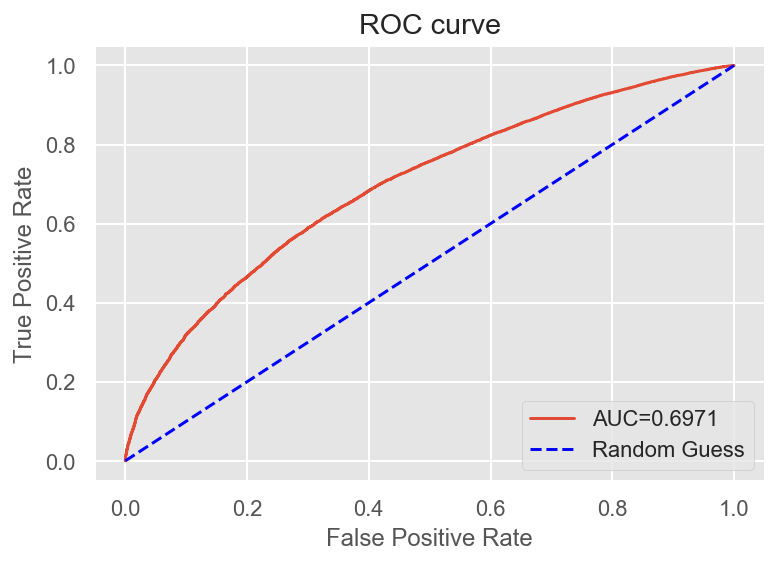

In [77]:
def plot_auc(ytx,yprobs_tx):

    from sklearn import metrics

    fpr, tpr, thresholds = metrics.roc_curve(ytx,  yprobs_tx)
    auc = metrics.roc_auc_score(ytx, yprobs_tx)

    plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot(fpr,fpr,ls='--',color='blue',label='Random Guess')
    plt.legend(loc=4)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    

plot_auc(ytx,yprobs_tx)

## Sort by yhat_prob and find Gini and Kolmogorov-Smirnov

- To calculate Gini we must sort data by yprobs.
- Gini is top left yellow part, not adjacent to 45 degree wedge.

![](../images/gini_1.png)
![](../images/KS_1.png)

In [78]:
ytest.head(2)

,good_bad,yprobs,yhat
193817,1,0.894002,1
174039,1,0.806717,1


In [79]:
ytest = ytest.sort_values('yprobs')
ytest.head()

,good_bad,yprobs,yhat
42396,0,0.431262,0
13858,1,0.457426,0
42368,0,0.463180,0
42398,0,0.463748,0
213386,1,0.469236,0


In [80]:
def get_yprobs_sorted_proportions(df_ytest,col_ytrue,col_yprobs):
    """Sort the df_ytest by predicted probabilities and return
       dataframe with various proportions.
       
    Parameters:
    ------------
    df_ytest: pd.core.frame.DataFrame
        Test dataframe
    col_ytrue: str
        Name of column for true label.
    col_yprobs: str
        Name of column for predicted probabilities 
    """

    df_ytest = df_ytest.sort_values(col_yprobs)
    n_test = len(df_ytest)
    sum_test = df_ytest[col_ytrue].sum()

    df_ytest['cum_n_pop'] = range(1,n_test+1)
    df_ytest['cum_n_good'] = df_ytest['good_bad'].cumsum()
    df_ytest['cum_n_bad'] = (df_ytest['cum_n_pop']
                             - df_ytest['cum_n_good'])

    df_ytest['cum_perc_pop'] = df_ytest['cum_n_pop'] / n_test
    df_ytest['cum_perc_good'] = df_ytest['cum_n_good'] / sum_test
    df_ytest['cum_perc_bad'] = (df_ytest['cum_n_bad'] 
                                / (n_test - sum_test))
    
    return df_ytest

ytest = get_yprobs_sorted_proportions(ytest,'good_bad','yprobs')
ytest.head(20)

,good_bad,yprobs,yhat,cum_n_pop,cum_n_good,cum_n_bad,cum_perc_pop,cum_perc_good,cum_perc_bad
42396,0,0.431262,0,1,0,1,0.000011,0.000000,0.000098
13858,1,0.457426,0,2,1,1,0.000021,0.000012,0.000098
42368,0,0.463180,0,3,1,2,0.000032,0.000012,0.000196
42398,0,0.463748,0,4,1,3,0.000043,0.000012,0.000294
213386,1,0.469236,0,5,2,3,0.000054,0.000024,0.000294
36242,1,0.473357,0,6,3,3,0.000064,0.000036,0.000294
42438,1,0.481632,0,7,4,3,0.000075,0.000048,0.000294
39932,0,0.491026,0,8,4,4,0.000086,0.000048,0.000392
41033,1,0.492590,0,9,5,4,0.000097,0.000060,0.000392
215253,0,0.495545,0,10,5,5,0.000107,0.000060,0.000491


## Plot Gini Curve

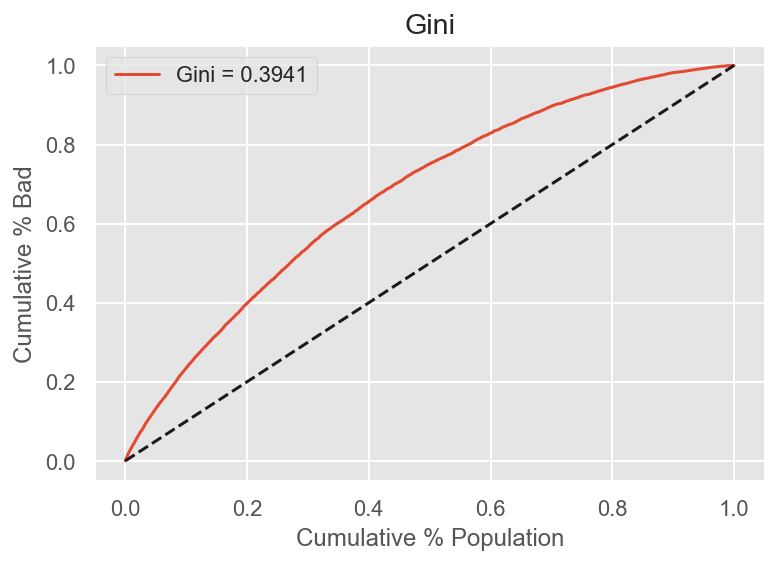

In [81]:
def plot_gini(df_ytest_proportions,col_ytrue,col_yprobs):
    """Plot Kolmogorov-Smirnov Curve.
    
    Parameters:
    ------------
    df_ytest_proportions: pd.core.frame.DataFrame
        Pandas dataframe with at least two columns:
        - cum_perc_pop
        - cum_perc_bad
        
    Usage:
    -------
    df_ytest = get_yprobs_sorted_proportions(
                   df_ytest,'ytrue','yprobs')
    
    plot_gini(df_ytest,'ytrue','yprobs')

    """
    from sklearn import metrics
    auc = metrics.roc_auc_score(
        df_ytest_proportions[col_ytrue],
        df_ytest_proportions[col_yprobs])

    gini = 2*auc-1

    x = df_ytest_proportions['cum_perc_pop']
    y = df_ytest_proportions['cum_perc_bad']

    plt.plot(x,y,label=f'Gini = {gini:.4f}')
    plt.plot(x,x,ls='--',c='k')

    plt.xlabel('Cumulative % Population')
    plt.ylabel('Cumulative % Bad')
    plt.title('Gini')

    plt.legend(loc=2)
    plt.show()

plot_gini(ytest,'good_bad','yprobs')

In [82]:
auc = metrics.roc_auc_score(ytx, yprobs_tx)
gini = auc * 2 - 1

print(auc,gini)

0.6970500431326075 0.3941000862652151


## Plot K-S curve

In [83]:
ytest.head(2)

,good_bad,yprobs,yhat,cum_n_pop,cum_n_good,cum_n_bad,cum_perc_pop,cum_perc_good,cum_perc_bad
42396,0,0.431262,0,1,0,1,0.000011,0.000000,0.000098
13858,1,0.457426,0,2,1,1,0.000021,0.000012,0.000098


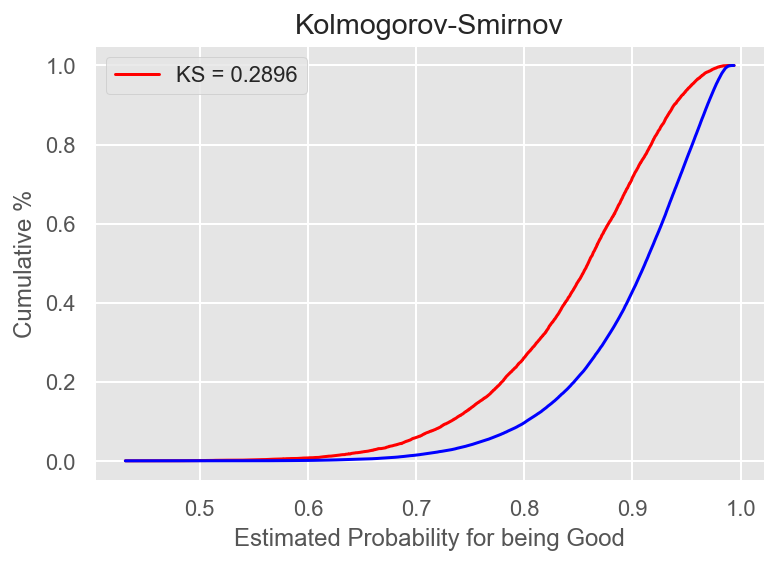

In [84]:
def plot_ks(df_ytest_proportions,col_yprobs,
            col_cum_perc_good,col_cum_perc_bad):
    """Plot Kolmogorov-Smirnov Curve.

    Parameters:
    ------------
    df_ytest_proportions: pd.core.frame.DataFrame
        Pandas dataframe with at least three columns:
        - yprob
        - cum_perc_good
        - cum_perc_bad
    col_yprobs: str
        Name of column for test probabilities
    col_cum_perc_good: str
        Name of column for cumulative percent for good
    col_cum_perc_bad: str
        Name of column for cumulative percent for bad

    Usage:
    -------
    df_ytest = get_yprobs_sorted_proportions(
                   df_ytest,'ytrue','yprobs')

    plot_ks(ytest,'yprobs','cum_perc_good','cum_perc_bad')
    """
    x = df_ytest_proportions[col_yprobs]
    y1 = df_ytest_proportions[col_cum_perc_bad]
    y2 = df_ytest_proportions[col_cum_perc_good]

    KS = max(  df_ytest_proportions[col_cum_perc_bad]
             - df_ytest_proportions[col_cum_perc_good]
            )
    KS = round(KS,4)
    
    plt.plot(x,y1,color='red',label=f'KS = {KS}')
    plt.plot(x,y2,color='blue')

    plt.xlabel('Estimated Probability for being Good')
    plt.ylabel('Cumulative %')
    plt.title('Kolmogorov-Smirnov')

    plt.legend(loc=2)
    plt.show()

plot_ks(ytest,'yprobs','cum_perc_good','cum_perc_bad')

In [85]:
KS = max(ytest['cum_perc_bad'] - ytest['cum_perc_good'])
KS

0.28957666094557605

# Create Scorecard

![](../images/score_variable.png)
![](../images/score_intercept.png)

In [91]:
df_summary.round(2).head(10)

,feature,coef,p_value,orig_feature,n_cats
0,intercept,3.08,NaN,intercept,1
1,grade:B,-0.35,0.00,grade,6
2,grade:C,-0.55,0.00,grade,6
3,grade:D,-0.72,0.00,grade,6
4,grade:E,-0.86,0.00,grade,6
5,grade:F,-1.01,0.00,grade,6
6,grade:G,-1.14,0.00,grade,6
7,home_ownership:OWN,0.11,0.00,home_ownership,2
8,home_ownership:MORTGAGE,0.14,0.00,home_ownership,2
9,addr_state:NM_VA,-0.02,0.49,addr_state,10


In [92]:
min_score = 300
max_score = 850

range_score = max_score - min_score
range_score

550

In [93]:
df_summary.groupby('orig_feature')['coef'].min()

orig_feature
addr_state                    -0.020646
annual_inc                    -0.157204
emp_length                     0.198978
grade                         -1.139969
home_ownership                 0.106299
initial_list_status            0.045202
inq_last_6mths                -0.454816
installment                   -0.703469
int_rate                      -0.805943
intercept                      3.079220
mths_since_earliest_cr_line    0.019069
mths_since_issue_d            -1.080057
mths_since_last_delinq        -0.117333
open_acc                      -0.284495
purpose                        0.299241
term                          -0.094063
total_rev_hi_lim               0.168161
verification_status           -0.041636
Name: coef, dtype: float64

In [94]:
min_sum_coef = df_summary.groupby('orig_feature')['coef'].sum().min()

max_sum_coef = df_summary.groupby('orig_feature')['coef'].sum().max()


range_sum_coef = max_sum_coef - min_sum_coef

min_sum_coef, max_sum_coef, range_sum_coef

(-7.94149194204161, 3.6866098990130527, 11.628101841054663)

In [95]:
df_scorecard = df_summary.drop('n_cats',axis=1)

In [96]:
range_score = max_score - min_score
range_sum_coef = max_sum_coef - min_sum_coef
factor = range_score / range_sum_coef

df_scorecard['score_raw'] = df_scorecard['coef'] * factor 

df_scorecard.head()

,feature,coef,p_value,orig_feature,score_raw
0,intercept,3.079220,NaN,intercept,145.644661
1,grade:B,-0.348211,1.250293e-15,grade,-16.470097
2,grade:C,-0.550283,4.663642e-30,grade,-26.027966
3,grade:D,-0.715277,4.720558e-43,grade,-33.832027
4,grade:E,-0.857529,7.101066e-50,grade,-40.560437


In [97]:
intercept = df_scorecard['coef'][0]
intercept_diff = intercept - min_score

intercept_score =  ((intercept_diff / range_sum_coef) * range_score
            + min_score)

intercept_score

-13744.1175420487

In [98]:
df_scorecard['score_raw'][0] = intercept_score

In [99]:
df_scorecard['score_prel'] = df_scorecard['score_raw'].round()
df_scorecard.head()

,feature,coef,p_value,orig_feature,score_raw,score_prel
0,intercept,3.079220,NaN,intercept,-13744.117542,-13744.0
1,grade:B,-0.348211,1.250293e-15,grade,-16.470097,-16.0
2,grade:C,-0.550283,4.663642e-30,grade,-26.027966,-26.0
3,grade:D,-0.715277,4.720558e-43,grade,-33.832027,-34.0
4,grade:E,-0.857529,7.101066e-50,grade,-40.560437,-41.0


In [100]:
min_sum_score_prel = df_scorecard.groupby('orig_feature')['score_prel'].min().sum()
min_sum_score_prel

-13936.0

In [101]:
max_sum_score_prel = df_scorecard.groupby('orig_feature')['score_prel'].max(). sum()
max_sum_score_prel

-13672.0

In [102]:
df_scorecard['score_diff'] = df_scorecard['score_prel'] - df_scorecard['score_raw']
df_scorecard.head()

,feature,coef,p_value,orig_feature,score_raw,score_prel,score_diff
0,intercept,3.079220,NaN,intercept,-13744.117542,-13744.0,0.117542
1,grade:B,-0.348211,1.250293e-15,grade,-16.470097,-16.0,0.470097
2,grade:C,-0.550283,4.663642e-30,grade,-26.027966,-26.0,0.027966
3,grade:D,-0.715277,4.720558e-43,grade,-33.832027,-34.0,-0.167973
4,grade:E,-0.857529,7.101066e-50,grade,-40.560437,-41.0,-0.439563


In [103]:
# if we have scores between 300 and 850, we dont have to modify.
# but, lets suppose due to rounding accumulation, max score is 851
# then we subtract 1 from highest difference score.
# find maximum difference variable

In [154]:
idx_max_diff = df_scorecard['score_diff'].argmax()
idx_max_diff

46

In [158]:
df_scorecard.loc[idx_max_diff]

feature         inq_last_6mths:1
coef                   -0.115751
p_value               6.0618e-19
orig_feature      inq_last_6mths
score_raw                -11.487
score_prel                   -11
score_diff              0.487035
Name: 46, dtype: object

In [160]:
new_value = df_scorecard.loc[idx_max_diff]['score_prel'] - 1
new_value

-12.0

In [166]:
df_scorecard['score'] = df_scorecard['score_prel']
df_scorecard['score'][idx_max_diff] = new_value

df_scorecard.head(10)

,feature,coef,p_value,orig_feature,score_raw,score_prel,score_diff,score
0,intercept,3.079220,NaN,intercept,703.177389,703.0,-0.177389,703.0
1,grade:B,-0.348211,1.250293e-15,grade,-34.556156,-35.0,-0.443844,-35.0
2,grade:C,-0.550283,4.663642e-30,grade,-54.609662,-55.0,-0.390338,-55.0
3,grade:D,-0.715277,4.720558e-43,grade,-70.983479,-71.0,-0.016521,-71.0
4,grade:E,-0.857529,7.101066e-50,grade,-85.100455,-85.0,0.100455,-85.0
5,grade:F,-1.011796,1.767375e-56,grade,-100.409816,-100.0,0.409816,-100.0
6,grade:G,-1.139969,1.025923e-51,grade,-113.129534,-113.0,0.129534,-113.0
7,home_ownership:OWN,0.106299,1.154583e-07,home_ownership,10.548980,11.0,0.451020,11.0
8,home_ownership:MORTGAGE,0.136705,8.024207e-28,home_ownership,13.566466,14.0,0.433534,14.0
9,addr_state:NM_VA,-0.020343,4.855318e-01,addr_state,-2.018819,-2.0,0.018819,-2.0


In [163]:
min_sum_score_prel = df_scorecard.groupby('orig_feature')['score'].min().sum()

min_sum_score_prel

301.0

In [164]:
max_sum_score_prel = df_scorecard.groupby('orig_feature')['score_prel'].max(). sum()
max_sum_score_prel

850.0

In [165]:
# we have both min and max between 300 and 850